In [1]:
import pandas as pd
import numpy as np

import codecs
import json

import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def unwrap_lucene_features(name, row):
    doc_scores = ['qScores', 'aScores', 'bothQAScores', 'bothQAScoresMustHave']
    doc_ids = ['qDocs', 'aDocs', 'bothQADoc', 'bothQADocAMustHave']

    d = row[name]

    for scores, docs in zip(doc_scores, doc_ids):
        d_scores = d[scores]
        std = np.std(d_scores)
        d[scores + '_mean'] = np.mean(d_scores)
        d[scores + '_std'] = std
        d[scores + '_median'] = np.median(d_scores)
        d[scores + '_doc_scores'] = zip(d[docs], d_scores)

        for i, score in enumerate(d_scores):
            d['%s_doc_%d' % (scores, i + 1)] = score
            d['%s_doc_%d_up' % (scores, i + 1)] = score + std
            d['%s_doc_%d_down' % (scores, i + 1)] = score - std

    blacklist = set(doc_scores + doc_ids)
    tuples = [(name + '_' + n, f) for (n, f) in d.items() if n not in blacklist]

    return dict(tuples)

In [3]:
lucene_features = ['ck12_ebook_ngrams']

def transform(row):
    for lucene_feature in lucene_features:
        lfs = unwrap_lucene_features(lucene_feature, row['luceneFeatures'])
        row.update(lfs)

    del row['luceneFeatures']
    del row['word2VecFeatures']
    return row

In [4]:
dicts = []

with codecs.open('/home/agrigorev/git-projects/allen-qa/lucene-features-7-concepts.json', 'r', 'utf-8') as f:
    for line in f:
        row = json.loads(line)
        row = transform(row)
        dicts.append(row)


In [5]:
questions = pd.DataFrame(dicts)
del dicts

In [6]:
questions.sort(columns=['questionId', 'answerLetter'], inplace=1)

In [7]:
questions.head()

,answer,answerLetter,ck12_ebook_ngrams_aScores_doc_1,ck12_ebook_ngrams_aScores_doc_10,ck12_ebook_ngrams_aScores_doc_10_down,ck12_ebook_ngrams_aScores_doc_10_up,ck12_ebook_ngrams_aScores_doc_1_down,ck12_ebook_ngrams_aScores_doc_1_up,ck12_ebook_ngrams_aScores_doc_2,ck12_ebook_ngrams_aScores_doc_2_down,ck12_ebook_ngrams_aScores_doc_2_up,ck12_ebook_ngrams_aScores_doc_3,ck12_ebook_ngrams_aScores_doc_3_down,ck12_ebook_ngrams_aScores_doc_3_up,ck12_ebook_ngrams_aScores_doc_4,ck12_ebook_ngrams_aScores_doc_4_down,ck12_ebook_ngrams_aScores_doc_4_up,ck12_ebook_ngrams_aScores_doc_5,ck12_ebook_ngrams_aScores_doc_5_down,ck12_ebook_ngrams_aScores_doc_5_up,
78636,[tissue level],A,2.914862,1.310292,0.766173,1.854412,2.370743,3.458982,2.702926,2.158806,3.247045,2.551398,2.007278,3.095517,2.163185,1.619065,2.707304,1.971255,1.427136,2.515375,...
78641,[organ level],B,6.497361,2.429563,1.112897,3.746229,5.180695,7.814027,5.158724,3.842058,6.475390,4.827022,3.510356,6.143688,4.741087,3.424421,6.057753,3.181255,1.864589,4.497921,...
78649,[system level],C,3.665062,1.854151,1.209421,2.498880,3.020332,4.309792,3.563983,2.919254,4.208713,3.372388,2.727658,4.017117,3.345207,2.700478,3.989937,3.312835,2.668105,3.957565,...
78654,[cellular level],D,9.657662,3.335558,0.621736,6.049379,6.943841,12.371484,9.657662,6.943841,12.371484,9.599337,6.885515,12.313158,8.442158,5.728336,11.155979,6.503883,3.790062,9.217705,...
78657,"[smell, air, odor]",A,4.996667,1.335892,0.049395,2.622389,3.710170,6.283165,4.859098,3.572601,6.145595,3.680152,2.393655,4.966649,2.218822,0.932325,3.505319,2.010784,0.724287,3.297281,...


### Let's find what numeric features are most accurate

In [8]:
train = questions[questions.source == 'TRAIN']

In [9]:
num = train._get_numeric_data()
numeric_features = list(num.columns)

In [10]:
results = []

for id, group in train.groupby('questionId'):
    row = {}
    row['correct'] = (group.label == 'true').values.argmax()

    for f in numeric_features:
        row[f] = group[f].values.argmax()
    
    results.append(row)

results = pd.DataFrame(results)

In [11]:
bf = []
for f in numeric_features:
    accucary = (results[f] == results.correct).mean()
    bf.append((f, accucary)) 
    
bf = pd.DataFrame(bf, columns=['feature', 'accuracy'])
bf.sort('accuracy', ascending=0)

,feature,accuracy
64,ck12_ebook_ngrams_bothQAScoresMustHave_doc_9_up,0.3844
49,ck12_ebook_ngrams_bothQAScoresMustHave_doc_4_up,0.3832
61,ck12_ebook_ngrams_bothQAScoresMustHave_doc_8_up,0.3832
38,ck12_ebook_ngrams_bothQAScoresMustHave_doc_10_up,0.3800
39,ck12_ebook_ngrams_bothQAScoresMustHave_doc_1_down,0.3800
58,ck12_ebook_ngrams_bothQAScoresMustHave_doc_7_up,0.3796
52,ck12_ebook_ngrams_bothQAScoresMustHave_doc_5_up,0.3784
55,ck12_ebook_ngrams_bothQAScoresMustHave_doc_6_up,0.3776
35,ck12_ebook_ngrams_bothQAScoresMustHave_doc_1,0.3772
43,ck12_ebook_ngrams_bothQAScoresMustHave_doc_2_up,0.3752


In [13]:
best_features = bf[bf.accuracy >= .30]
len(best_features)

72

In [14]:
boolean_features = pd.DataFrame(dict(questionId=questions.questionId, 
                                     answerLetter=questions.answerLetter, 
                                     source=questions.source, 
                                     label=questions.label))

In [17]:
def chunks(l, n):
    for i in xrange(0, len(l), n):
        yield l[i:i+n]

In [18]:
def to_boolean(series):
    series = np.array(series)

    res = np.zeros_like(series, dtype=int)    
    for i, chunk in enumerate(chunks(series, 4)):
        max = np.max(chunk)
        max_ids, = np.where(chunk == max)
        if len(max_ids) == 4:
            continue
        for id in max_ids:
            res[4 * i + id] = 1
    return res

In [19]:
for f in best_features.feature:
    boolean_features[f + 'max'] = to_boolean(  questions[f])
    boolean_features[f + 'min'] = to_boolean(- questions[f])

In [20]:
total = best_features.accuracy.sum() 

In [21]:
feature_weights = dict((f, a / total) for (f, a) in zip(bf.feature, bf.accuracy) if a >= 0.35)
features, weights = zip(*feature_weights.items())
features = list(features)
weights = list(weights)

In [22]:
all_features = [f + 'max' for f in features] + [f + 'min' for f in features]

## Training

In [23]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from scipy import sparse
from collections import Counter

In [199]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

In [233]:
from sklearn.decomposition import randomized_svd
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection

In [443]:
train = boolean_features[boolean_features.source == 'TRAIN']

In [444]:
y = (train.label == 'true').astype(int).values

In [31]:
def calc_accuracy(y, y_score):
    questions = chunks(zip(y, y_score),  4)

    total = 0
    correct = 0
    for chunk in questions:
        y_chunk, y_score_chunk = zip(*chunk)
        correct = correct + (np.argmax(y_chunk) == np.argmax(y_score_chunk))
        total = total + 1
    
    return 1.0 * correct / total

calc_accuracy(y, train.ck12_ebook_ngrams_bothQAScores_doc_8_upmax.values)

0.4148

In [32]:
def train_test_split(X, y, n_iter=5, test_size=0.25):
    if sparse.issparse(X):
        X = X.tocsr()
    n = len(y) / 4

    split = cross_validation.ShuffleSplit(n=n, n_iter=n_iter, test_size=test_size)

    for train, test in split:
        train_idx = np.repeat(train, 4) * 4 + np.arange(len(train) * 4) % 4
        test_idx  = np.repeat(test, 4) * 4  + np.arange(len(test) * 4) % 4
        
        yield (X[train_idx], y[train_idx], X[test_idx], y[test_idx])

In [34]:
X_0 = train[all_features].values

In [486]:
accs = []
for X_train, y_train, X_test, y_test in train_test_split(X_0, y, n_iter=10, test_size=0.1):
    clf = LogisticRegressionCV()
    clf.fit(X_train, y_train)

    y_score = clf.predict_proba(X_test)[:, 1]
    acc = calc_accuracy(y_test, y_score)
    accs.append(acc)
    
mean_acc = np.mean(accs)
print '%0.3f ± %0.3f' % (mean_acc, np.std(accs))

0.432 ± 0.027


In [485]:
accs = []

for X_train, y_train, X_test, y_test in train_test_split(X_0, y, n_iter=10, test_size=0.1):
    clf = SVC()
    clf.fit(X_train, y_train)

    #y_score = clf.predict_proba(X_val)[:, 1]
    y_score = clf.decision_function(X_test)
    acc = calc_accuracy(y_test, y_score)
    accs.append(acc)
    # print acc, roc_auc_score(y_test, y_score)
mean_acc = np.mean(accs)
print '%0.3f ± %0.3f' % (mean_acc, np.std(accs))

0.410 ± 0.020


In [484]:
accs = []

for X_train, y_train, X_test, y_test in train_test_split(X_0, y, n_iter=10, test_size=0.1):
    clf = LinearSVC()
    clf.fit(X_train, y_train)

    #y_score = clf.predict_proba(X_val)[:, 1]
    y_score = clf.decision_function(X_test)
    acc = calc_accuracy(y_test, y_score)
    accs.append(acc)
    # print acc, roc_auc_score(y_test, y_score)
mean_acc = np.mean(accs)
print '%0.3f ± %0.3f' % (mean_acc, np.std(accs))

0.425 ± 0.025


In [483]:
accs = []

for X_train, y_train, X_test, y_test in train_test_split(X_0, y, n_iter=10, test_size=0.1):
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(X_train, y_train)

    y_score = clf.predict_proba(X_test)[:, 1]
    acc = calc_accuracy(y_test, y_score)
    accs.append(acc)
    # print acc, roc_auc_score(y_test, y_score)
mean_acc = np.mean(accs)
print '%0.3f ± %0.3f' % (mean_acc, np.std(accs))

0.296 ± 0.019


In [560]:
accs = []
for X_train, y_train, X_test, y_test in train_test_split(X_0, y, n_iter=50, test_size=0.1):
    nmf = NMF(n_components=2, init='random')
    X_train_red = nmf.fit_transform(X_train)

    clf = LogisticRegressionCV()
    clf.fit(X_train_red, y_train)

    X_test_red = nmf.transform(X_test)
    y_score = clf.predict_proba(X_test_red)[:, 1]
    acc = calc_accuracy(y_test, y_score)
    accs.append(acc)
    print acc, roc_auc_score(y_test, y_score)
    
mean_acc = np.mean(accs)
print '%0.3f ± %0.3f' % (mean_acc, np.std(accs))

0.432 0.685416
0.464 0.705813333333
0.408 0.675448
0.396 0.640090666667
0.388 0.626786666667
0.424 0.662522666667
0.42 0.648997333333
0.456 0.66088
0.416 0.656373333333
0.404 0.650514666667
0.452 0.665456
0.416 0.642570666667
0.376 0.645424
0.416 0.659754666667
0.376 0.628898666667
0.412 0.670242666667
0.416 0.64864
0.448 0.655746666667
0.4 0.642216
0.42 0.661090666667
0.4 0.638936
0.444 0.670853333333
0.436 0.652432
0.42 0.636624
0.416 0.644317333333
0.36 0.615370666667
0.396 0.654104
0.464 0.679501333333
0.456 0.686512
0.404 0.638338666667
0.388 0.623693333333
0.376 0.610042666667
0.38 0.642005333333
0.408 0.656738666667
0.428 0.675621333333
0.416 0.654554666667
0.416 0.659608
0.408 0.65116
0.508 0.705845333333
0.46 0.680274666667
0.392 0.65644
0.484 0.684224
0.412 0.620058666667
0.408 0.674336
0.436 0.645632
0.464 0.678093333333
0.416 0.672762666667
0.396 0.638090666667
0.424 0.662008
0.424 0.645688
0.420 ± 0.029


In [578]:
nmf = NMF(n_components=2, init='random')
X_0_red = nmf.fit_transform(X_0)

In [580]:
calc_accuracy(y, X_0_red[:, 1])

0.4216

In [481]:
accs = []
for X_train, y_train, X_test, y_test in train_test_split(X_0, y, n_iter=10, test_size=0.1):
    nmf = TruncatedSVD(n_components=10)
    X_train_red = nmf.fit_transform(X_train)

    clf = LogisticRegressionCV()
    clf.fit(X_train_red, y_train)

    X_test_red = nmf.transform(X_test)
    y_score = clf.predict_proba(X_test_red)[:, 1]
    acc = calc_accuracy(y_test, y_score)
    accs.append(acc)
    
mean_acc = np.mean(accs)
print '%0.3f ± %0.3f' % (mean_acc, np.std(accs))

0.422 ± 0.038


In [240]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [480]:
accs = []
for X_train, y_train, X_test, y_test in train_test_split(X_0, y, n_iter=10, test_size=0.1):
    clf = GradientBoostingClassifier()
    clf.fit(X_train, y_train)

    y_score = clf.predict_proba(X_test)[:, 1]
    acc = calc_accuracy(y_test, y_score)
    accs.append(acc)
    
mean_acc = np.mean(accs)
print '%0.3f ± %0.3f' % (mean_acc, np.std(accs))

0.418 ± 0.037


In [479]:
accs = []
for X_train, y_train, X_test, y_test in train_test_split(X_0, y, n_iter=10, test_size=0.1):
    clf = ExtraTreesClassifier(n_estimators=100)
    clf.fit(X_train, y_train)

    y_score = clf.predict_proba(X_test)[:, 1]
    acc = calc_accuracy(y_test, y_score)
    accs.append(acc)
    
mean_acc = np.mean(accs)
print '%0.3f ± %0.3f' % (mean_acc, np.std(accs))

0.365 ± 0.015


In [263]:
from sklearn.preprocessing import minmax_scale

In [272]:
ensembles = []

idx_features = np.arange(len(all_features))

for _ in range(100):
    ensembles.append(np.random.choice(idx_features, size=5, replace=0))

In [478]:
accs = []
for X_train, y_train, X_test, y_test in train_test_split(X_0, y, n_iter=10, test_size=0.1):
    y_score = np.zeros_like(y_test)

    for en in ensembles:
        clf = LogisticRegression()
        clf.fit(X_train[:, en], y_train)

        y_score = y_score + minmax_scale(clf.predict_proba(X_test[:, en])[:, 1])

    acc = calc_accuracy(y_test, y_score)
    accs.append(acc)
    print 'iteration, acc = %0.3f' % acc
    
mean_acc = np.mean(accs)
print '%0.3f ± %0.3f' % (mean_acc, np.std(accs))

iteration, acc = 0.444
iteration, acc = 0.404
iteration, acc = 0.376
iteration, acc = 0.388
iteration, acc = 0.376
iteration, acc = 0.388
iteration, acc = 0.412
iteration, acc = 0.436
iteration, acc = 0.428
iteration, acc = 0.400
0.405 ± 0.023


### Feature Importances

In [274]:
X_imp = train[all_features]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_imp.values, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [275]:
importances = clf.feature_importances_
indices = np.argsort(importances)

names = X_imp.iloc[0].keys()

Most important features:

In [285]:
most_important = names[indices].values[-11:]
most_important

array(['ck12_ebook_ngrams_bothQAScores_doc_7max',
       'ck12_ebook_ngrams_bothQAScoresMustHave_doc_3min',
       'ck12_ebook_ngrams_bothQAScores_doc_4max',
       'ck12_ebook_ngrams_bothQAScores_doc_8max',
       'ck12_ebook_ngrams_bothQAScores_doc_4_upmax',
       'ck12_ebook_ngrams_bothQAScoresMustHave_doc_2_downmin',
       'ck12_ebook_ngrams_bothQAScores_doc_2_upmax',
       'ck12_ebook_ngrams_bothQAScores_doc_9max',
       'ck12_ebook_ngrams_bothQAScores_doc_3max',
       'ck12_ebook_ngrams_bothQAScores_doc_2_downmax',
       'ck12_ebook_ngrams_bothQAScores_doc_2_downmin'], dtype=object)

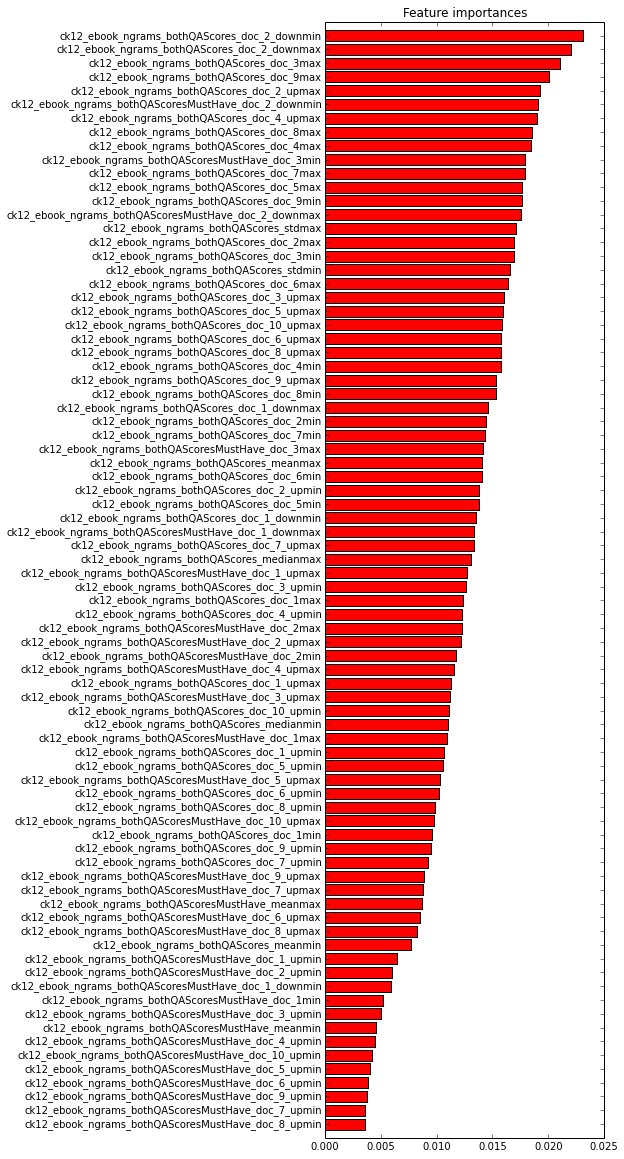

In [278]:
no_features = len(names)

plt.figure(figsize=(5, 20))
plt.title("Feature importances")
plt.barh(range(no_features), importances[indices], color="r", align="center")

plt.yticks(range(no_features), names[indices])
plt.ylim([-1, no_features])

plt.show()

In [290]:
X_1 = train[most_important].values

In [429]:
most_important

array(['ck12_ebook_ngrams_bothQAScores_doc_7max',
       'ck12_ebook_ngrams_bothQAScoresMustHave_doc_3min',
       'ck12_ebook_ngrams_bothQAScores_doc_4max',
       'ck12_ebook_ngrams_bothQAScores_doc_8max',
       'ck12_ebook_ngrams_bothQAScores_doc_4_upmax',
       'ck12_ebook_ngrams_bothQAScoresMustHave_doc_2_downmin',
       'ck12_ebook_ngrams_bothQAScores_doc_2_upmax',
       'ck12_ebook_ngrams_bothQAScores_doc_9max',
       'ck12_ebook_ngrams_bothQAScores_doc_3max',
       'ck12_ebook_ngrams_bothQAScores_doc_2_downmax',
       'ck12_ebook_ngrams_bothQAScores_doc_2_downmin'], dtype=object)

In [477]:
accs = []
for X_train, y_train, X_test, y_test in train_test_split(X_1, y, n_iter=10, test_size=0.1):
    clf = LogisticRegressionCV()
    clf.fit(X_train, y_train)

    y_score = clf.predict_proba(X_test)[:, 1]
    acc = calc_accuracy(y_test, y_score)
    accs.append(acc)
    print 'iteration, acc = %0.3f' % acc
    
mean_acc = np.mean(accs)
print '%0.3f ± %0.3f' % (mean_acc, np.std(accs))

iteration, acc = 0.448
iteration, acc = 0.372
iteration, acc = 0.364
iteration, acc = 0.416
iteration, acc = 0.392
iteration, acc = 0.444
iteration, acc = 0.388
iteration, acc = 0.396
iteration, acc = 0.424
iteration, acc = 0.376
0.402 ± 0.028


## Similarity b/w q and a

In [297]:
def identity_analyzer(x):
    return x

In [359]:
questions_train = questions[questions.source == 'TRAIN']

In [360]:
all_text = list(questions_train.question.iloc[::4]) + list(questions_train.answer)

In [361]:
qa_tfidf = TfidfVectorizer(analyzer=identity_analyzer, min_df=1)
qa_tfidf.fit(all_text)

TfidfVectorizer(analyzer=<function identity_analyzer at 0x7fa7915e6c08>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), norm=u'l2',
        preprocessor=None, smooth_idf=True, stop_words=None,
        strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [362]:
text_all = sparse.vstack([qa_tfidf.transform(questions_train.question[::4]), 
                          qa_tfidf.transform(questions_train.answer)])

In [363]:
svd = TruncatedSVD(n_components=150)
svd.fit(text_all)

TruncatedSVD(algorithm='randomized', n_components=150, n_iter=5,
       random_state=None, tol=0.0)

In [364]:
question_vecs = svd.transform(qa_tfidf.transform(questions_train.question))
answer_vecs = svd.transform(qa_tfidf.transform(questions_train.answer))

In [365]:
svd_sim = []
for q, a in zip(question_vecs, answer_vecs):
    svd_sim.append(q.dot(a))

In [368]:
svd_sim = np.array(svd_sim)

In [370]:
calc_accuracy(y, svd_sim)

0.2988

In [371]:
all_text = list(questions_train.ngramsQuestion.iloc[::4]) + list(questions_train.ngramsAnswer)

In [372]:
qa_tfidf = TfidfVectorizer(analyzer=identity_analyzer, min_df=1)
qa_tfidf.fit(all_text)

TfidfVectorizer(analyzer=<function identity_analyzer at 0x7fa7915e6c08>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), norm=u'l2',
        preprocessor=None, smooth_idf=True, stop_words=None,
        strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [373]:
text_all = sparse.vstack([qa_tfidf.transform(questions_train.ngramsQuestion[::4]), 
                          qa_tfidf.transform(questions_train.ngramsAnswer)])

In [374]:
svd = TruncatedSVD(n_components=150)
svd.fit(text_all)

TruncatedSVD(algorithm='randomized', n_components=150, n_iter=5,
       random_state=None, tol=0.0)

In [375]:
question_vecs = svd.transform(qa_tfidf.transform(questions_train.question))
answer_vecs = svd.transform(qa_tfidf.transform(questions_train.answer))

In [377]:
svd_sim_ngram = []
for q, a in zip(question_vecs, answer_vecs):
    svd_sim_ngram.append(q.dot(a))

In [379]:
svd_sim_ngram = np.array(svd_sim_ngram)

In [381]:
calc_accuracy(y, svd_sim_ngram)

0.3044

### LSA on q/a docs

In [507]:
from sklearn.feature_extraction import DictVectorizer

In [508]:
all_docs_train = \
    list(questions_train.ck12_ebook_ngrams_qScores_doc_scores[::4].apply(dict)) + \
    list(questions_train.ck12_ebook_ngrams_aScores_doc_scores.apply(dict))

In [509]:
dv = DictVectorizer()
dv.fit(all_docs_train)

DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True)

In [510]:
q_vec = dv.transform(list(questions.ck12_ebook_ngrams_qScores_doc_scores.apply(dict)))
a_vec = dv.transform(list(questions.ck12_ebook_ngrams_aScores_doc_scores.apply(dict)))


In [511]:
sim_vec = []
for q, a in zip(q_vec, a_vec):
    qa = (q * a.T)
    if qa:
        sim_vec.append(qa.data[0])
    else:
        sim_vec.append(0.0)

sim_vec = np.array(sim_vec)

In [512]:
questions['ck12_qa_doc_sim'] = sim_vec

In [513]:
calc_accuracy(y, sim_vec[questions.source.values == 'TRAIN'])

0.41

In [514]:
q_vec_train = dv.transform(list(questions_train.ck12_ebook_ngrams_qScores_doc_scores.iloc[::4].apply(dict)))
a_vec_train = dv.transform(list(questions_train.ck12_ebook_ngrams_aScores_doc_scores.apply(dict)))

all_docs = sparse.vstack([q_vec_train, a_vec_train])

In [515]:
svd_doc = TruncatedSVD(n_components=300)
svd_doc.fit(all_docs)

TruncatedSVD(algorithm='randomized', n_components=300, n_iter=5,
       random_state=None, tol=0.0)

In [516]:
q_vec_svd = svd_doc.transform(q_vec)
a_vec_svd = svd_doc.transform(a_vec)

In [517]:
doc_sim_svd = []
for q, a in zip(q_vec_svd, a_vec_svd):
    doc_sim_svd.append(q.dot(a))

doc_sim_svd =  np.array(doc_sim_svd)

In [522]:
questions['ck12_qa_doc_sim_svd'] = doc_sim_svd

In [523]:
calc_accuracy(y, doc_sim_svd[questions.source.values == 'TRAIN'])

0.4104

In [526]:
boolean_features['ck12_qa_doc_sim_svd_max'] = to_boolean(doc_sim_svd)
boolean_features['ck12_qa_doc_sim_max'] = to_boolean(sim_vec)

In [527]:
docsim = boolean_features[['ck12_qa_doc_sim_svd_max', 'ck12_qa_doc_sim_max']]
train_docsim = docsim[boolean_features.source == 'TRAIN']

In [529]:
train_docsim.shape, train[most_important].values.shape

((10000, 2), (10000, 11))

Let's try to build a model with it

In [530]:
X_2 = np.hstack([train[most_important].values, train_docsim.values])

In [531]:
accs = []
for X_train, y_train, X_test, y_test in train_test_split(X_2, y, n_iter=10, test_size=0.1):
    clf = LogisticRegressionCV()
    clf.fit(X_train, y_train)

    y_score = clf.predict_proba(X_test)[:, 1]
    acc = calc_accuracy(y_test, y_score)
    accs.append(acc)
    print 'iteration, acc = %0.3f' % acc
    
mean_acc = np.mean(accs)
print '%0.3f ± %0.3f' % (mean_acc, np.std(accs))

iteration, acc = 0.444
iteration, acc = 0.416
iteration, acc = 0.404
iteration, acc = 0.452
iteration, acc = 0.452
iteration, acc = 0.388
iteration, acc = 0.444
iteration, acc = 0.452
iteration, acc = 0.428
iteration, acc = 0.408
0.429 ± 0.022


In [591]:
nmf = NMF(n_components=2, init='random')
X_0_red = nmf.fit_transform(X_0)


In [592]:
X_2 = np.hstack([X_0_red, train_docsim.values])

In [593]:
accs = []
for X_train, y_train, X_test, y_test in train_test_split(X_2, y, n_iter=50, test_size=0.1):
    clf = LogisticRegressionCV()
    clf.fit(X_train, y_train)

    y_score = clf.predict_proba(X_test)[:, 1]
    acc = calc_accuracy(y_test, y_score)
    accs.append(acc)
    # print 'iteration, acc = %0.3f' % acc
    
mean_acc = np.mean(accs)
print '%0.3f ± %0.3f' % (mean_acc, np.std(accs))

0.433 ± 0.028


In [595]:
X_0_red[5]

array([ 0.83828337,  0.07775487])

Let's save the features

In [594]:
nmf = NMF(n_components=2, init='random')
X_0_red = nmf.fit_transform(X_0)

In [605]:
nmf_all = nmf.transform(boolean_features[all_features].values)

In [610]:
X_ck12 = np.hstack([X_0_red, train_docsim.ck12_qa_doc_sim_svd_max.values.reshape(-1, 1)])

In [611]:
accs = []
for X_train, y_train, X_test, y_test in train_test_split(X_ck12, y, n_iter=50, test_size=0.1):
    clf = LogisticRegressionCV()
    clf.fit(X_train, y_train)

    y_score = clf.predict_proba(X_test)[:, 1]
    acc = calc_accuracy(y_test, y_score)
    accs.append(acc)
    # print 'iteration, acc = %0.3f' % acc

mean_acc = np.mean(accs)
print '%0.3f ± %0.3f' % (mean_acc, np.std(accs))

0.426 ± 0.030


In [616]:
#to_boolean(questions['ck12_qa_doc_sim_svd'].values
features = pd.DataFrame({
              'questionId': questions.questionId, 
              'answerLetter': questions.answerLetter, 
              'source': questions.source,
              'label': questions.label, 
              'ck12_qa_doc_sim_svd': docsim.ck12_qa_doc_sim_svd_max,
              'ck12_nmf_0': nmf_all[:, 0],
              'ck12_nmf_1': nmf_all[:, 1]},
            columns=['questionId', 'answerLetter', 'source', 'label', 
                     'ck12_qa_doc_sim_svd', 'ck12_nmf_0', 'ck12_nmf_1'])

In [617]:
features.to_csv('/home/agrigorev/git-projects/allen-qa/features/ck12_features.txt', index=0, sep='\t')

## Submission

In [42]:
test = boolean_features[questions.source == 'TEST']
test_docsim = docsim[boolean_features.source == 'TEST']

In [582]:
X_0_test = test[all_features].values
X_0_test_red = nmf.transform(X_0_test)

In [583]:
calc_accuracy(y, X_0_red[:, 1])

0.4208

In [587]:
y_score = X_0_test_red[:, 1]

In [546]:
X_2_test = np.hstack([X_0_test_red, test_docsim.values])

In [547]:
clf = LogisticRegressionCV()
clf.fit(X_2, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [548]:
y_score = clf.predict_proba(X_2_test)[:, 1]

In [588]:
idx = np.arange(len(test))

val_index = pd.DataFrame({'idx': idx, 'questionId': test.questionId, 
                          'answer': test.answerLetter,
                          'score': y_score})
val_index.head(n=8)

,answer,idx,questionId,score
52382,A,0,102501,0.000000
52383,B,1,102501,0.000000
52386,C,2,102501,1.224320
52388,D,3,102501,0.000000
52390,A,4,102502,0.000000
52393,B,5,102502,0.383347
52394,C,6,102502,0.172953
52397,D,7,102502,0.670249


In [589]:
result = []

for id, group in val_index.groupby('questionId'):
    answer_idx = group.score.values.argmax()
    answer = group.answer.values[answer_idx]
    result.append((id, answer))

In [590]:
res = pd.DataFrame(result, columns=['id', 'correctAnswer'])
res.to_csv('/home/agrigorev/git-projects/allen-qa/test_result.csv', index=0)

Majority Vote

In [192]:
result = []

for id, group in test.groupby('questionId'):
    row = {'questionId': id}
    for f in features:
        answer_idx = group[f + 'max'].values.argmax()
        answer = group.answerLetter.values[answer_idx]
        row[f] = answer

    result.append(row)

result = pd.DataFrame(result)

def majority_vote(row):
    cnt = Counter()
    cnt.setdefault(lambda x: 0.0)
    for pred, weight in zip(row[features].values, weights):
        cnt[pred] = cnt[pred] + weight

    (lab, _), = cnt.most_common(1)
    return lab

mvote = result.apply(majority_vote, axis=1)

In [198]:
mvote_res = pd.DataFrame({'id': result.questionId, 'correctAnswer': mvote}, columns=['id', 'correctAnswer'])
mvote_res.to_csv('/home/agrigorev/git-projects/allen-qa/test_result_mvote.csv', index=0)